In [1]:
import pandas as pd
import csv
import numpy as np

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

seed = 42
torch.manual_seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

np.random.seed(seed)
random.seed(seed)

%matplotlib inline

use_cuda = torch.cuda.is_available()

In [2]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
                
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

def filterPair(p):
    return len(p[0]) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def getChars(item):
    return [element for element in item]

In [3]:
def get_data(file_range):
    print('File range:', list(file_range))
    data_list = []
    for i in file_range:
        index = str(i)
        if len(index) == 1:
            filename = 'output-0000{}-of-00100'.format(index)
        elif len(index) == 2:
            filename = 'output-000{}-of-00100'.format(index)
        else:
            raise ValueError('Wrong index')

        cur_data = pd.read_csv('../input/ru_with_types/' + filename, sep='\t', names=['class', 'before', 'after'],
                           quoting=csv.QUOTE_NONE, encoding='utf-8', dtype=str)

        if (cur_data.shape[0] > 1074563-10) and (cur_data.shape[0] < 1074563+10):
            print(filename)
        data_list.append(cur_data)
        print('Data shape for item {} is {}'.format(i,cur_data.shape))


    data_orig = pd.concat(data_list, axis=0)
    print('Overall data shape is {}'.format(data_orig.shape))
    
    return data_orig

In [5]:
data_dev = get_data(range(0,2))
data_learn = get_data(range(5,8))

File range: [0, 1]
Data shape for item 0 is (2973646, 3)
Data shape for item 1 is (2981069, 3)
Overall data shape is (5954715, 3)
File range: [5, 6, 7]
Data shape for item 5 is (2975471, 3)
Data shape for item 6 is (2980056, 3)
Data shape for item 7 is (2975255, 3)
Overall data shape is (8930782, 3)


In [6]:
data_train = pd.read_csv('../input/ru_train.csv', dtype = str)
#data_test = pd.read_csv('../input/ru_test.csv', dtype = str)
data_train.shape

(10574516, 5)

In [7]:
MAX_LENGTH = 100

In [8]:
def make_sample(data_learn, self_frac = 0.33, sil_frac = 1):

    data_nn = data_learn.copy()
    to_concat = []
    to_concat.append(data_nn[(data_nn.after != '<self>') & (data_nn.after != 'sil')])
    to_concat.append(data_nn[data_nn.after == '<self>'].sample(frac = self_frac))
    to_concat.append(data_nn[data_nn.after == 'sil'].sample(frac = sil_frac))

    data_nn = pd.concat(to_concat, axis=0)
    return data_nn

In [9]:
#data_nn = make_sample(data_learn)
#data_dev = make_sample(data_dev, self_frac=1.0)

In [10]:
#data_nn.head()

In [11]:
#data_orig = pd.concat([data_nn, data_dev], axis=0)

In [12]:
def get_pairs(data_orig, filter_length = MAX_LENGTH):

    big_str = list(data_orig.before.astype(str).values)
    output_list = list(data_orig.after.astype(str).values)
    types_list = list(data_orig['class'].values)
    
    stride = 3
    input_list = []
    pairs = []
    for i in range(len(big_str)):
        if big_str[i] != '<eos>':
            #print(big_str[i])
            cur_item = ['<norm>'] + getChars(big_str[i]) + ['</norm>']
            cur_type = types_list[i]
            #cur_item = ['<{}>'.format(cur_type)] + cur_item + ['</{}>'.format(cur_type)]
            #print(big_str[i-stride:i])
            prefix = getChars(' '.join(big_str[i-stride:i]))
            #print(prefix)
            prefix = ' '.join(prefix).split('< e o s >')[-1].split(' ')
            #print(prefix)
            suffix = getChars(' '.join(big_str[i+1:i+stride+1]))
            suffix = ' '.join(suffix).split('< e o s >')[0].split(' ')
            cur_item = prefix \
            + cur_item + \
            suffix

            cur_item = ' '.join(cur_item)
            cur_item = cur_item.replace('  ', ' ')
            cur_item = cur_item.replace('  ', ' ')
            if cur_item[0] == ' ':
                cur_item = cur_item[1:]
            pairs += [(cur_item, output_list[i], cur_type)]

    #pairs = list(zip(input_list, output_list))
    print('Len of pairs:', len(pairs))
    
    if filter_length:
        pairs = filterPairs(pairs)
        print('Len of pairs after filtering:', len(pairs))
    return pairs

In [13]:
list(range(3))[-4:2]

[0, 1]

In [14]:
train_pairs = get_pairs(data_learn)
dev_pairs = get_pairs(data_dev)

Len of pairs: 8319218
Len of pairs after filtering: 6885865
Len of pairs: 5547039
Len of pairs after filtering: 4592529


In [15]:
train_pairs[:10]

[('<norm> Д р у г а я </norm> в е р с и я б е р е т н а ч а л о',
  '<self>',
  'PLAIN'),
 ('<norm> в е р с и я </norm> б е р е т н а ч а л о о т', '<self>', 'PLAIN'),
 ('<norm> б е р е т </norm> н а ч а л о о т с л о в а', '<self>', 'PLAIN'),
 ('Д р у г а я в е р с и я б е р е т <norm> н а ч а л о </norm> о т с л о в а "',
  '<self>',
  'PLAIN'),
 ('в е р с и я б е р е т н а ч а л о <norm> о т </norm> с л о в а " н е п е я',
  '<self>',
  'PLAIN'),
 ('б е р е т н а ч а л о о т <norm> с л о в а </norm> " н е п е я "',
  '<self>',
  'PLAIN'),
 ('н а ч а л о о т с л о в а <norm> " </norm> н е п е я " -', 'sil', 'PUNCT'),
 ('о т с л о в а " <norm> н е п е я </norm> " - ч е л о в е к а',
  '<self>',
  'PLAIN'),
 ('с л о в а " н е п е я <norm> " </norm> - ч е л о в е к а в е д у щ е г о',
  'sil',
  'PUNCT'),
 ('" н е п е я " <norm> - </norm> ч е л о в е к а в е д у щ е г о т р е з в ы й',
  'sil',
  'VERBATIM')]

In [16]:
dev_pairs[:10]

[('<norm> П о </norm> с о с т о я н и ю н а 1 8 6 2 г о д', '<self>', 'PLAIN'),
 ('<norm> с о с т о я н и ю </norm> н а 1 8 6 2 г о д .', '<self>', 'PLAIN'),
 ('<norm> н а </norm> 1 8 6 2 г о д . ', '<self>', 'PLAIN'),
 ('П о с о с т о я н и ю н а <norm> 1 8 6 2 г о д </norm> . ',
  'тысяча восемьсот шестьдесят второй год',
  'DATE'),
 ('с о с т о я н и ю н а 1 8 6 2 г о д <norm> . </norm> ', 'sil', 'PUNCT'),
 ('<norm> О с н а щ а л и с ь </norm> л а т н ы м и р у к а в и ц а м и и',
  '<self>',
  'PLAIN'),
 ('О с н а щ а л и с ь <norm> л а т н ы м и </norm> р у к а в и ц а м и и с а б а т о н а м и',
  '<self>',
  'PLAIN'),
 ('О с н а щ а л и с ь л а т н ы м и <norm> р у к а в и ц а м и </norm> и с а б а т о н а м и с',
  '<self>',
  'PLAIN'),
 ('О с н а щ а л и с ь л а т н ы м и р у к а в и ц а м и <norm> и </norm> с а б а т о н а м и с н е',
  '<self>',
  'PLAIN'),
 ('л а т н ы м и р у к а в и ц а м и и <norm> с а б а т о н а м и </norm> с н е д л и н н ы м и',
  '<self>',
  'PLAIN'

In [17]:
input_lang, output_lang = Lang('nonnorm'), Lang('norm')

for pair in train_pairs + dev_pairs:
    input_lang.addSentence(pair[0])
    output_lang.addSentence(pair[1])

In [18]:
#tst[tst.before != tst.after]

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_output, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]))
        return output, hidden, attn_weights

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result

In [20]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)

In [21]:
teacher_forcing_ratio = 0.5


def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
   
    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_output, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input
            
            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [23]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  # SOS
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_output, encoder_outputs)
        decoder_attentions[di] = decoder_attention.data
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])
        
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words, decoder_attentions[:di + 1]

In [25]:
def trainIters(encoder, decoder, pairs, n_iters, print_every=1000, plot_every=100, learning_rate=0.01, evaluate_each=False):
    start = time.time()
    plot_losses = []
    plot_accuracies = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]
 
        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
            
        if evaluate_each and iter % evaluate_each == 0 and iter != 0:
            preds = np.array([(item[1], ' '.join(evaluate(encoder, decoder, item[0])[0][:-1]), item[0]) for item in test_pairs])
            results = np.array([item[0] == item[1] for item in preds])
            print('\t\t eval accuracy: {:.3f}'.format(results.mean()))
            plot_accuracies.append(results.mean())

    showPlot(plot_losses)
    showPlot(plot_accuracies)
    
    return plot_losses

Using CUDA
11m 8s (- 2217m 23s) (10000 0%) 0.8614
20m 15s (- 2005m 20s) (20000 1%) 0.5160
29m 24s (- 1931m 35s) (30000 1%) 0.4258
38m 35s (- 1891m 5s) (40000 2%) 0.4118
47m 43s (- 1861m 2s) (50000 2%) 0.3910
		 eval accuracy: 0.855
60m 16s (- 1948m 57s) (60000 3%) 0.3435
69m 17s (- 1910m 24s) (70000 3%) 0.3364
78m 16s (- 1878m 42s) (80000 4%) 0.3062
87m 15s (- 1851m 51s) (90000 4%) 0.2898
96m 13s (- 1828m 11s) (100000 5%) 0.2959
		 eval accuracy: 0.874
108m 40s (- 1867m 16s) (110000 5%) 0.2741
117m 39s (- 1843m 22s) (120000 6%) 0.2492
126m 35s (- 1821m 5s) (130000 6%) 0.2477
135m 32s (- 1800m 48s) (140000 7%) 0.2253
144m 28s (- 1781m 47s) (150000 7%) 0.2168
		 eval accuracy: 0.884
156m 53s (- 1804m 13s) (160000 8%) 0.2034
165m 47s (- 1784m 44s) (170000 8%) 0.1955
174m 42s (- 1766m 25s) (180000 9%) 0.2022
183m 35s (- 1748m 57s) (190000 9%) 0.1848
192m 27s (- 1732m 5s) (200000 10%) 0.1683
		 eval accuracy: 0.900
204m 47s (- 1745m 38s) (210000 10%) 0.1751
213m 37s (- 1728m 28s) (220000 11

1664m 24s (- 248m 42s) (1740000 87%) 0.0779
1673m 20s (- 239m 2s) (1750000 87%) 0.0696
		 eval accuracy: 0.946
1685m 40s (- 229m 51s) (1760000 88%) 0.0730
1694m 34s (- 220m 11s) (1770000 88%) 0.0743
1703m 30s (- 210m 32s) (1780000 89%) 0.0741
1712m 22s (- 200m 53s) (1790000 89%) 0.0685
1721m 17s (- 191m 15s) (1800000 90%) 0.0708
		 eval accuracy: 0.943
1733m 39s (- 181m 59s) (1810000 90%) 0.0674
1742m 31s (- 172m 20s) (1820000 91%) 0.0736
1751m 21s (- 162m 41s) (1830000 91%) 0.0732
1760m 10s (- 153m 3s) (1840000 92%) 0.0629
1769m 2s (- 143m 26s) (1850000 92%) 0.0670
		 eval accuracy: 0.949
1781m 22s (- 134m 4s) (1860000 93%) 0.0721
1790m 15s (- 124m 27s) (1870000 93%) 0.0780
1799m 9s (- 114m 50s) (1880000 94%) 0.0718
1808m 1s (- 105m 13s) (1890000 94%) 0.0727
1816m 53s (- 95m 37s) (1900000 95%) 0.0711
		 eval accuracy: 0.945
1829m 14s (- 86m 11s) (1910000 95%) 0.0748
1838m 7s (- 76m 35s) (1920000 96%) 0.0719
1847m 0s (- 66m 59s) (1930000 96%) 0.0730
1855m 55s (- 57m 23s) (1940000 97%) 

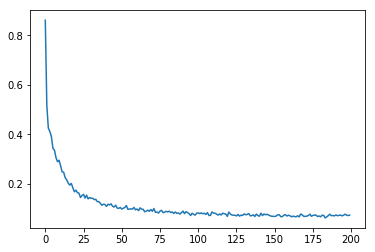

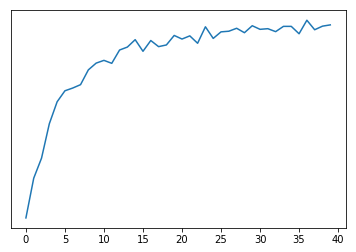

In [32]:
torch.backends.cudnn.enabled = False
test_pairs = dev_pairs[:10000]


hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size, n_layers=2)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                           n_layers =2, dropout_p=0.1)

if use_cuda:
    print('Using CUDA')
    encoder1 = encoder1.cuda()
    attn_decoder1 = attn_decoder1.cuda()

callback_num = 10000
plot_losses = trainIters(encoder1, attn_decoder1, train_pairs, 2000000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=50000)

10m 0s (- 991m 19s) (10000 1%) 0.0716
19m 7s (- 936m 56s) (20000 2%) 0.0660
28m 11s (- 911m 21s) (30000 3%) 0.0642
37m 15s (- 894m 2s) (40000 4%) 0.0750
46m 19s (- 880m 13s) (50000 5%) 0.0783
		 eval accuracy: 0.945
58m 57s (- 923m 37s) (60000 6%) 0.0748
68m 4s (- 904m 24s) (70000 7%) 0.0711
77m 7s (- 886m 55s) (80000 8%) 0.0685
86m 14s (- 872m 1s) (90000 9%) 0.0708
95m 18s (- 857m 49s) (100000 10%) 0.0752
		 eval accuracy: 0.946
107m 59s (- 873m 47s) (110000 11%) 0.0675
117m 6s (- 858m 49s) (120000 12%) 0.0722
126m 9s (- 844m 18s) (130000 13%) 0.0721
135m 16s (- 830m 57s) (140000 14%) 0.0749
144m 21s (- 818m 0s) (150000 15%) 0.0733
		 eval accuracy: 0.945
157m 3s (- 824m 33s) (160000 16%) 0.0709
166m 10s (- 811m 18s) (170000 17%) 0.0687
175m 13s (- 798m 14s) (180000 18%) 0.0720
184m 17s (- 785m 41s) (190000 19%) 0.0703
193m 24s (- 773m 38s) (200000 20%) 0.0763
		 eval accuracy: 0.945
206m 3s (- 775m 9s) (210000 21%) 0.0711
215m 7s (- 762m 43s) (220000 22%) 0.0733
224m 14s (- 750m 43s)

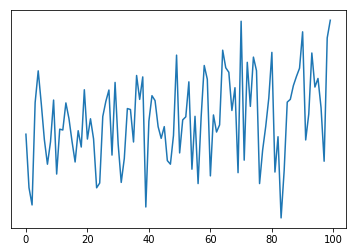

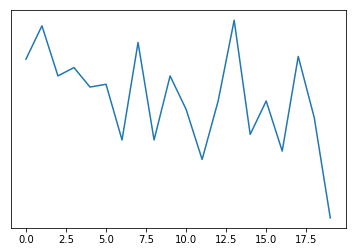

In [33]:
plot_losses = trainIters(encoder1, attn_decoder1, train_pairs, 1000000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=50000)

9m 33s (- 468m 22s) (10000 2%) 0.0770
18m 35s (- 446m 11s) (20000 4%) 0.0663
27m 39s (- 433m 24s) (30000 6%) 0.0677
36m 49s (- 423m 32s) (40000 8%) 0.0638
45m 53s (- 413m 5s) (50000 10%) 0.0647
		 eval accuracy: 0.947
58m 34s (- 429m 35s) (60000 12%) 0.0581
67m 38s (- 415m 30s) (70000 14%) 0.0609
76m 43s (- 402m 46s) (80000 16%) 0.0598
85m 47s (- 390m 51s) (90000 18%) 0.0645
94m 53s (- 379m 35s) (100000 20%) 0.0613
		 eval accuracy: 0.952
107m 34s (- 381m 24s) (110000 22%) 0.0596
116m 39s (- 369m 26s) (120000 24%) 0.0525
125m 45s (- 357m 55s) (130000 26%) 0.0580
134m 51s (- 346m 47s) (140000 28%) 0.0635
143m 56s (- 335m 50s) (150000 30%) 0.0581
		 eval accuracy: 0.953
156m 34s (- 332m 44s) (160000 32%) 0.0554
165m 36s (- 321m 29s) (170000 34%) 0.0523
174m 40s (- 310m 31s) (180000 36%) 0.0563
183m 42s (- 299m 43s) (190000 38%) 0.0583
192m 43s (- 289m 4s) (200000 40%) 0.0504
		 eval accuracy: 0.954
205m 16s (- 283m 28s) (210000 42%) 0.0534
214m 17s (- 272m 43s) (220000 44%) 0.0520
223m 2

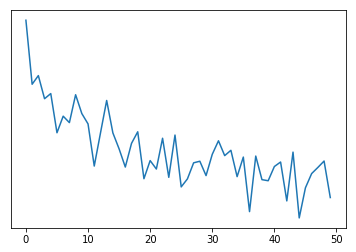

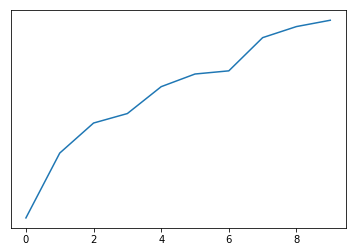

In [34]:
plot_losses = trainIters(encoder1, attn_decoder1, train_pairs, 500000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=50000, learning_rate = 0.001)

In [35]:
plot_losses = trainIters(encoder1, attn_decoder1, train_pairs, 150000, print_every=callback_num, 
                         plot_every=callback_num, evaluate_each=50000, learning_rate = 0.0001)

9m 12s (- 128m 51s) (10000 6%) 0.0526
18m 14s (- 118m 31s) (20000 13%) 0.0540
27m 14s (- 108m 56s) (30000 20%) 0.0541
36m 17s (- 99m 48s) (40000 26%) 0.0522
45m 21s (- 90m 43s) (50000 33%) 0.0481
		 eval accuracy: 0.960
57m 54s (- 86m 52s) (60000 40%) 0.0455
66m 56s (- 76m 30s) (70000 46%) 0.0468
75m 58s (- 66m 28s) (80000 53%) 0.0503
85m 1s (- 56m 41s) (90000 60%) 0.0515
94m 7s (- 47m 3s) (100000 66%) 0.0581
		 eval accuracy: 0.960


KeyboardInterrupt: 

In [ ]:
ind_to_test = -51

print(input_list[ind_to_test])
evaluate(encoder1, attn_decoder1, input_list[ind_to_test])[0]

In [36]:
test_pairs = dev_pairs[:5000]


preds = np.array([(item[1], ' '.join(evaluate(encoder1, attn_decoder1, item[0])[0][:-1]), item[0]) for item in test_pairs])

In [37]:
results = np.array([item[0] == item[1] for item in preds] )

In [38]:
results.mean()

0.95899999999999996

In [39]:
results_norm = np.array([item[0].lower() == item[1].lower() for item in preds] )
results_norm.mean()

0.95899999999999996

In [42]:
preds[~results][2]

array(['о_trans с_trans п_trans е_trans к_trans с_trans',
       'о_trans с_trans п_trans е_trans с_trans с_trans',
       'T i b e r i u s J u l i u s P o l l i e n u s <norm> A u s p e x </norm> ) — р и м с к и й'],
      dtype='<U181')

In [ ]:
ind_to_test = 5

print(input_list[ind_to_test])
evaluate(encoder1, attn_decoder1, input_list[ind_to_test])[0]

In [ ]:
input_list[0]